In [223]:
import numpy as np
from numpy import asarray
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage
from skimage.segmentation import clear_border
from skimage import data, exposure, img_as_float
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import label,regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import io, color, segmentation
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import blend_modes
import plotly.graph_objects as go
import pandas as pd
import pvlib
from skimage.draw import line, line_aa




# angulo de elevacion

# filepath = '20230807_normal/20230807152030.png'
# filepath = '20230807_normal/20230807152100.png'

# filepath = '20230807_normal/20230807163300.png'
# filepath = '20230807_normal/20230807100030.png'
# filepath = '20230807_normal/20230807192000.png'
# filepath = '20230807_normal/20230807175600.png'
# filepath = '20230807_normal/20230807210600.png'
# filepath = '20230807_normal/20230807211330.png'

def TwoDToRGBA (img):
    background_img_raw = img
    background_img = np.array(background_img_raw)  # Inputs to blend_modes need to be numpy arrays.
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGBA image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # Copy the rescaled values to the first three channels (RGB)
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # Set the alpha channel to a constant value (255 for fully opaque)
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (480, 640, 4)
    return rgba_image

def TwoDToRGB(img):
    background_img_raw = img
    background_img = np.array(background_img_raw)  # Inputs to blend_modes need to be numpy arrays.
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGB image with the rescaled content
    rgb_image = np.zeros((background_img.shape[0], background_img.shape[1], 3), dtype=np.uint8)
    # Copy the rescaled values to all three channels (RGB)
    rgb_image[:, :, :] = scaled_img[:, :, np.newaxis]
    # Now 'rgb_image' is an RGB image with dimensions (height, width, 3)
    return rgb_image

def create_radial_gradient(size, center, radius):

    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient, opacity):
    # Inputs to blend_modes need to be floats.
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)

    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)  # Image needs to be converted back to uint8 type for PIL handling.
    # blended_img_raw = Image.fromarray(blended_img)  # Note that alpha channels are displayed in black by PIL by default.
    return blended_img

def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

def segmentation (filepath):
    img = Image.open(filepath)
    img = asarray(img)
    raw = img
    
    camara = Image.open('camara.png')
    camara = asarray(camara)
    slicee = camara[:,:,3]
    img = img* slicee
    
    from_array = Image.fromarray(img)
    im_flip = ImageOps.flip(from_array)
    im_rotate = im_flip.rotate(-3, center=(314, 235))
    img = asarray(im_rotate)
    
    rgba_image = TwoDToRGBA (img)

    # rgba_image = TwoDToRBGA (img)

    image_size = img.shape
    gradient_center = (235, 314)  # Center of the gradient
    gradient_radius = 200  # Radius of the gradient
    gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_1 = TwoDToRGBA (gradient_1)
    
    gradient_radius = 250  # Radius of the gradient
    gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_2 = TwoDToRGBA (gradient_2)
    
    
    first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
    second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 0)
    twoDArray = second_grad[:,:,0]
    non_zero_mask = twoDArray != 0
    non_zero_values = twoDArray[non_zero_mask]
    average_non_zero = np.mean(non_zero_values)
    std_non_zero = np.std(non_zero_values)
    # print("Average of non-zero values:", average_non_zero)
    # print("Standard deviation of non-zero values:", std_non_zero)
    mask =  (second_grad[:,:,0] > average_non_zero+std_non_zero*2/3)
    
    mask.shape
    mask = clear_border(mask)
    
    
    big_mask = remove_small(mask)
    mask_labeled = label(big_mask)
    
    small_area_img = first_grad[:,:,0] * big_mask
    
    output_img = TwoDToRGB(small_area_img)
    
    # labels = label(output_img,connectivity=1,background=0)
    # rps = regionprops(labels)
    # areas = np.array([r.area for r in rps])
    return mask_labeled, output_img


# filepath = '20230807_normal/20230807152030.png'
# filepath = '20230807_normal/20230807152100.png'

# prev_mask, prev_img = segmentation('20230807_normal/20230807152030.png')
# mask, img = segmentation('20230807_normal/20230807152100.png')

# prev_mask, prev_img = segmentation('20230807_normal/20230807171730.png')
# mask, img = segmentation('20230807_normal/20230807171800.png')

prev_mask, prev_img = segmentation('20230807_normal/20230807180130.png')
mask, img = segmentation('20230807_normal/20230807180200.png')

import cv2

# plt.imshow(prev_img)
# plt.imshow(mask)

# plt.pcolormesh(mask)


import time
# import os


def draw_flow(img, flow, step=10):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr

def draw_hsv(flow):

    hsv = np.zeros_like(img)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return bgr, mag, ang, hsv

prevgray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# start time to calculate FPS
start = time.time()

flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
# prevgray = gray

# End time
end = time.time()
# calculate the FPS for current frame detection
fps = 1 / (end-start)
print(f"{fps:.2f} FPS")

draw_flow_img = draw_flow(gray, flow)
draw_flow_prev = draw_flow(prevgray, flow)
draw_hsv_img, mag, ang, hsv = draw_hsv(flow)
# cv2.imshow('flow', draw_flow_img)
# cv2.imshow('flow_prev', draw_flow_prev)
# cv2.imshow('flow HSV', draw_hsv_img)
key = cv2.waitKey(5)

# cv2.imwrite('flow.png', draw_flow_img)
# cv2.imwrite('hsv.png', draw_hsv_img)

# cv2.waitKey(0)
cv2.destroyAllWindows()


#### Label for velocity 
# Read the image
image = draw_hsv_img
# Convert the image to the Lab color space
image_lab = color.rgb2lab(image)
# Separate the L, a, and b channels
L, a, b = image_lab[:, :, 0], image_lab[:, :, 1], image_lab[:, :, 2]
# Use Otsu's thresholding on the L channel to create a binary mask
thresh = threshold_otsu(L)
binary_mask = L > thresh
small_binary = remove_small(binary_mask)
# Label connected components in the binary mask
labeled_image, num_labels = label(small_binary, connectivity=2, return_num=True)
# Display the original image, binary mask, and labeled image
# io.imshow(image)
# io.show()

# io.imshow(labeled_image)
# io.show()



for num in range(1,num_labels+1):
    mask = labeled_image == num
    x_flow = flow[:,:,0] * mask
    y_flow = flow[:,:,1] * mask
    non_zero_elements_x = x_flow[x_flow != 0]
    non_zero_elements_y = y_flow[y_flow != 0]
    average_non_zero_x = np.average(non_zero_elements_x)
    average_non_zero_y = np.average(non_zero_elements_y)
    
    over_img = img[:,:,0] * mask
    mask_over_img = over_img !=0
    small_ovr = remove_small(mask_over_img, c=0.0001)
    label_over_small, small_id = label(small_ovr, return_num=True)

    for labl in range(1,small_id+1): 
        centroide = measure.centroid(label_over_small == labl)   
        line_img = cv2.arrowedLine(img,
                            (int(centroide[1]), int(centroide[0])),
                            (int(centroide[1] + average_non_zero_x * 5), int(centroide[0] + average_non_zero_y * 5)),
                            (0,255,0), 2)
        
        
# io.imshow(line_img)



# solpos.apparent_zenith['2023-08-07 18:01:30-05:00']


tz = 'America/Bogota'
lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
altitude = 50

#Ubicación Geográfica
location = pvlib.location.Location(lat, lon, tz, altitude)

times = pd.date_range('2023-01-01 00:00:00', '2023-12-31', closed='left',
                      freq='H', tz=tz)
solpos = pvlib.solarposition.get_solarposition(times, lat, lon)

# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]


# draw hour labels
for hour in np.unique(solpos.index.hour):
    # choose label position by the smallest radius for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    # ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

# draw individual days
for date in pd.to_datetime(['2023-03-20', '2023-06-21', '2023-09-23', '2023-12-22', '2023-08-08']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='30s', tz=tz)
    solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%Y-%m-%d')
    azimuth_radians = np.radians(solpos.azimuth)

14.50 FPS


C:\Users\rodhe\AppData\Local\Temp\ipykernel_9308\2595531793.py:291: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  times = pd.date_range('2023-01-01 00:00:00', '2023-12-31', closed='left',


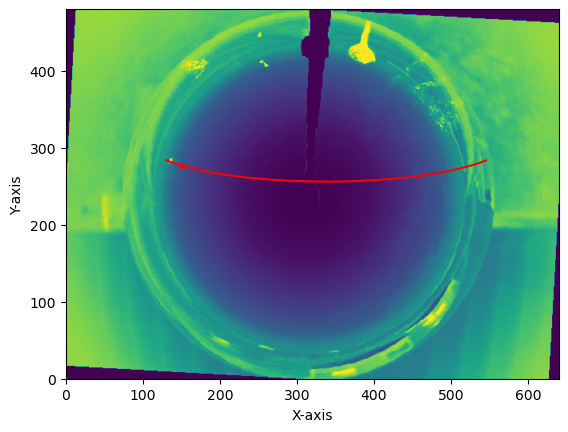

In [224]:
# filepath = '20230807_normal/20230807180200.png'


filepath = '20230808_normal/20230808112930.png'
# filepath = '20230808_normal/20230808140700.png'
# filepath = '20230808_normal/20230808162300.png'
# filepath = '20230808_normal/20230808175830.png'
# filepath = '20230808_normal/20230808190630.png'
# filepath = '20230808_normal/20230808201030.png'
# filepath = '20230808_normal/20230808213400.png'

img = Image.open(filepath)
img = asarray(img)
raw = img
camara = Image.open('camara.png')
camara = asarray(camara)
slicee = camara[:,:,3]
img = img* slicee
from_array = Image.fromarray(img)
im_flip = ImageOps.flip(from_array)
im_rotate = im_flip.rotate(-3.2, center=(314, 235))
img = asarray(im_rotate)
pic = img

# Convert polar coordinates to Cartesian coordinates without adjusting for polar plot settings
x_direct = solpos.apparent_zenith * np.sin(azimuth_radians)
y_direct = solpos.apparent_zenith * np.cos(azimuth_radians)
# Scale and map Cartesian coordinates to fit within the image dimensions
x_mapped = (-(x_direct / max(np.abs(x_direct))) * (img.shape[1] / 2) + img.shape[1] / 2)/1.54 + 130
y_mapped = ((y_direct / max(np.abs(y_direct))) * (img.shape[0] / 2) + img.shape[0] / 2 )/6.5 + 210

# Create a figure and axis for the image
fig, ax = plt.subplots()

# Display the image as the background
ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

# Overlay the points on top of the image
# ax.plot(x_mapped[100], y_mapped[100], 'ro', label=label)
# ax.plot(x_mapped[0], y_mapped[0], 'ro', label=label)

ax.plot(x_mapped['2023-08-08 06:29:30-05:00'], y_mapped['2023-08-08 06:29:30-05:00'], 'r.', label=label)
# ax.plot(x_mapped['2023-08-08 09:07:00-05:00'], y_mapped['2023-08-08 09:07:00-05:00'], 'r.', label=label)
# ax.plot(x_mapped['2023-08-08 11:23:00-05:00'], y_mapped['2023-08-08 11:23:00-05:00'], 'r.', label=label)
# ax.plot(x_mapped['2023-08-08 12:58:30-05:00'], y_mapped['2023-08-08 12:58:30-05:00'], 'r.', label=label)
# ax.plot(x_mapped['2023-08-08 14:06:30-05:00'], y_mapped['2023-08-08 14:06:30-05:00'], 'r.', label=label)
# ax.plot(x_mapped['2023-08-08 15:10:30-05:00'], y_mapped['2023-08-08 15:10:30-05:00'], 'r.', label=label)
# ax.plot(x_mapped['2023-08-08 16:34:00-05:00'], y_mapped['2023-08-08 16:34:00-05:00'], 'r.', label=label)

ax.plot(x_mapped, y_mapped,'r' , label=label)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
# plt.legend()
plt.show()

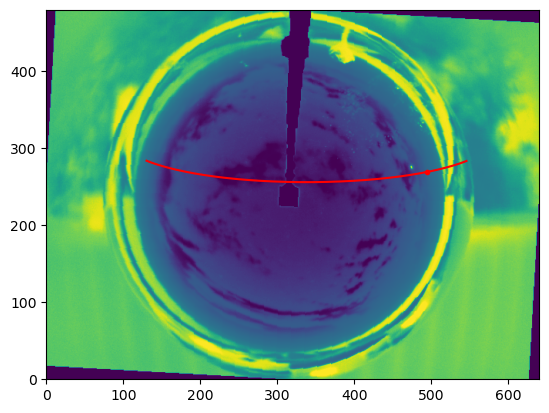

In [225]:
# filepath = '20230808_normal/20230808112930.png'
# filepath = '20230808_normal/20230808140700.png'
# filepath = '20230808_normal/20230808162300.png'
# filepath = '20230808_normal/20230808175830.png'
# filepath = '20230808_normal/20230808190630.png'
# filepath = '20230808_normal/20230808201030.png'
filepath = '20230808_normal/20230808213400.png'

st = filepath[-10:-4]
hh = str(int(st[0:2])-5)
if len(hh) == 1:
    hh = '0'+hh
mm = st[2:4]
ss = st[4:6]
timer = hh + ':'+ mm + ':' + ss

img = Image.open(filepath)
img = asarray(img)
raw = img
camara = Image.open('camara.png')
camara = asarray(camara)
slicee = camara[:,:,3]
img = img* slicee
from_array = Image.fromarray(img)
im_flip = ImageOps.flip(from_array)
im_rotate = im_flip.rotate(-3.2, center=(314, 235))
img = asarray(im_rotate)

# Convert polar coordinates to Cartesian coordinates without adjusting for polar plot settings
x_direct = solpos.apparent_zenith * np.sin(azimuth_radians)
y_direct = solpos.apparent_zenith * np.cos(azimuth_radians)
# Scale and map Cartesian coordinates to fit within the image dimensions
x_mapped = (-(x_direct / max(np.abs(x_direct))) * (img.shape[1] / 2) + img.shape[1] / 2)/1.54 + 130
y_mapped = ((y_direct / max(np.abs(y_direct))) * (img.shape[0] / 2) + img.shape[0] / 2 )/6.5 + 210


# Create a figure and axis for the image


fig, ax = plt.subplots()
ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])
ax.plot(x_mapped['2023-08-08 ' + timer + '-05:00'], y_mapped['2023-08-08 ' + timer + '-05:00'], 'r.', label=label)
ax.plot(x_mapped, y_mapped,'r' , label=label)
plt.show()


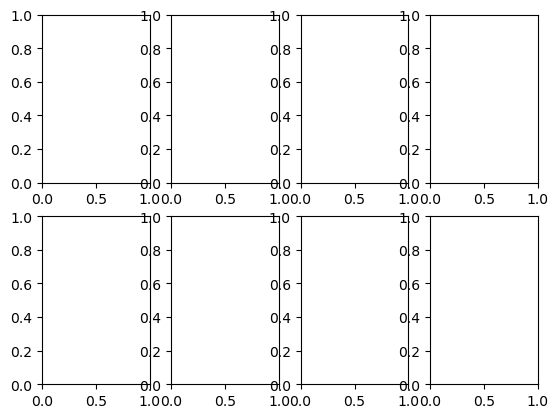

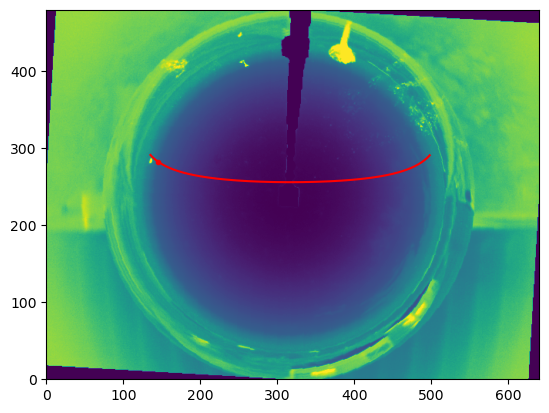

77.63861188676215 20.635988985997347


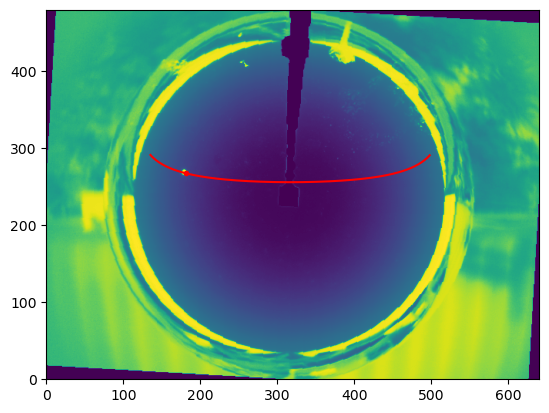

54.68850336764916 12.534926125559615


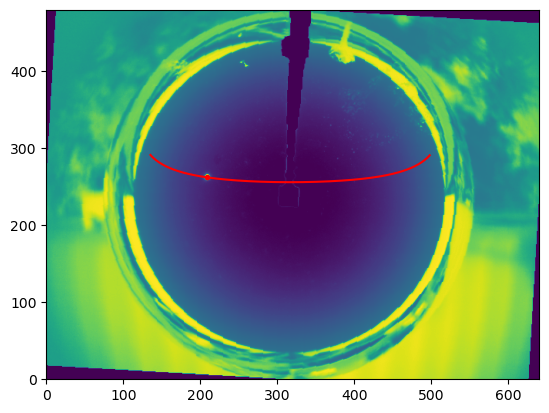

41.543610332366356 9.732472455847923


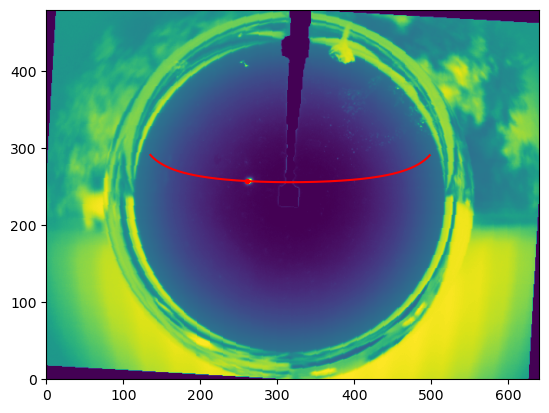

19.966738635104846 7.049385013413994


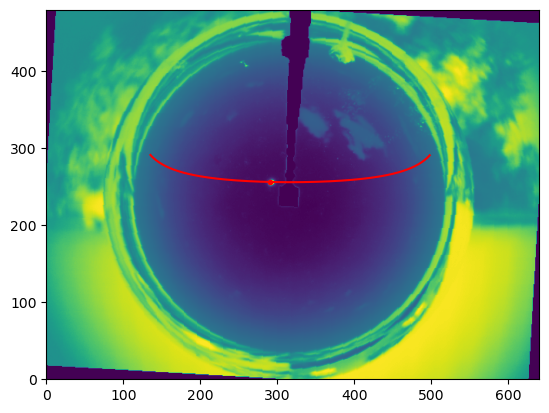

9.037870189932958 6.438701340747038


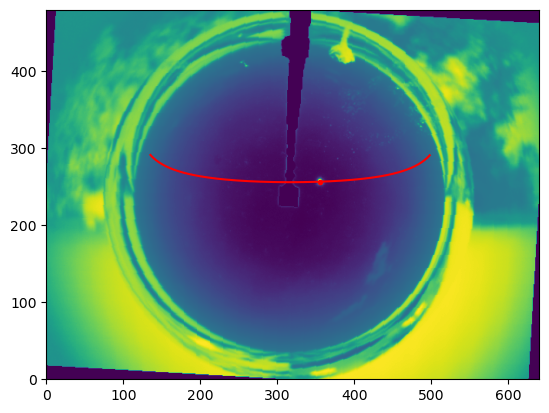

-13.937346261129598 6.631757659719931


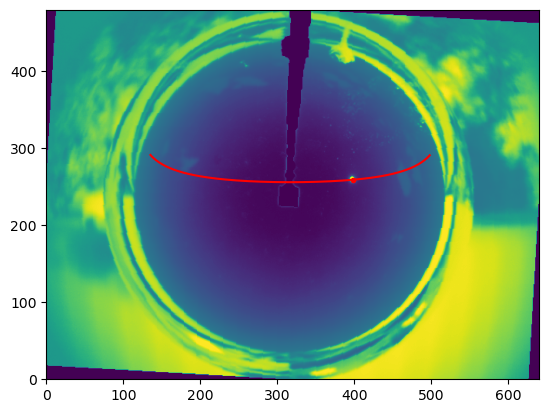

-30.23237859454969 8.011015618713934


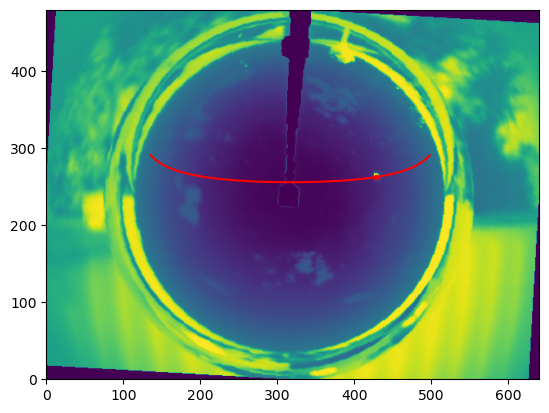

-43.30185683422545 9.968845966552353


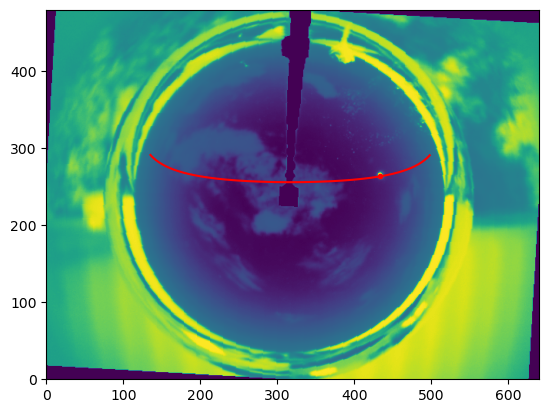

-45.42623974135272 10.369191101480837


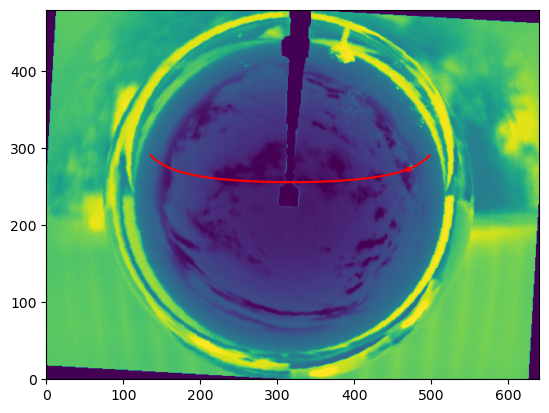

-64.83431290278033 15.355761817089505


<Figure size 640x480 with 0 Axes>

In [226]:
# filepath = '20230808_normal/20230808112930.png'
# filepath = '20230808_normal/20230808140700.png'
# filepath = '20230808_normal/20230808162300.png'
# filepath = '20230808_normal/20230808175830.png'
# filepath = '20230808_normal/20230808190630.png'
# filepath = '20230808_normal/20230808201030.png'
# filepath = '20230808_normal/20230808213400.png'

def create_graph(filepath):
    st = filepath[-10:-4]
    hh = str(int(st[0:2])-5)
    if len(hh) == 1:
        hh = '0'+hh
    mm = st[2:4]
    ss = st[4:6]
    timer = hh + ':'+ mm + ':' + ss

    img = Image.open(filepath)

    img = asarray(img)
    raw = img
    camara = Image.open('camara.png')
    camara = asarray(camara)
    slicee = camara[:,:,3]
    img = img* slicee
    from_array = Image.fromarray(img)
    im_flip = ImageOps.flip(from_array)
    im_rotate = im_flip.rotate(-3.3, center=(314, 235))
    img = asarray(im_rotate)

    # Convert polar coordinates to Cartesian coordinates
    x_direct = solpos.apparent_zenith * np.sin(azimuth_radians)
    y_direct = solpos.apparent_zenith * np.cos(azimuth_radians)


    x = -(x_direct)*2.84+312
    k=0.0086 
    x0=312
    a=85
    L=463
    x_mapped = L / (1 + np.exp(-k * (x - x0))) + a
    o = 6.4
    y_mapped =  y_direct*1.84 + 238 + o

    # Create a figure and axis for the imag
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])
    ax.plot(x_mapped['2023-08-08 ' + timer + '-05:00'], y_mapped['2023-08-08 ' + timer + '-05:00'], 'r.', label=label)
    ax.plot(x_mapped, y_mapped,'r' , label=label)
    plt.show()
    print(x_direct['2023-08-08 ' + timer + '-05:00'], y_direct['2023-08-08 ' + timer + '-05:00'])

# Create a 4x4 subplot grid
fig, axs = plt.subplots(2, 4)
# Call your function and add the graph to the first subplot (index 0)
create_graph('20230808_normal/20230808112930.png')
axs[0, 0].set_title('Graph 1')  # Set title for the first subplot
create_graph('20230808_normal/20230808131100.png')
axs[0, 0].set_title('Graph 1')  # Set title for the first subplot
create_graph('20230808_normal/20230808140700.png')
axs[0, 1].set_title('Graph 2')  # Set title for the second subplot
create_graph('20230808_normal/20230808153730.png')
axs[0, 1].set_title('Graph 2')  # Set title for the second subplot
create_graph('20230808_normal/20230808162300.png')
axs[0, 1].set_title('Graph 3')  # Set title for the second subplot
create_graph('20230808_normal/20230808175830.png')
axs[0, 1].set_title('Graph 4')  # Set title for the second subplot
create_graph('20230808_normal/20230808190630.png')
axs[0, 1].set_title('Graph 5')  # Set title for the second subplot
create_graph('20230808_normal/20230808200130.png')
axs[0, 1].set_title('Graph 6')  # Set title for the second subplot
create_graph('20230808_normal/20230808201030.png')
axs[0, 1].set_title('Graph 6')  # Set title for the second subplot
create_graph('20230808_normal/20230808213400.png')
axs[0, 1].set_title('Graph 7')  # Set title for the second subplot

# Repeat this process for other subplots as needed

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()